This notebook replicated results from visual behavior novelty paper, figure 4 (plus some supplemental figures). 

The steps include:
loading GLM output for each cell
select cells that were imaged during days of interests (Familiar, Novel, Novel+). 
select only matched cells

Optimal number of clusters with Gap statistic

Constructing coclustering matrix with optimal k

Applying hierarchical clustering on coclustering matrix to obrain robust cluster id assignment for each neuron

Visualize clusters

Visualize clusters by cre line

Perform area and depth analysis for the clusters
visualize distribution of clusters by area and depth
perform statistical analysis across areas and depths




# Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


# import visual_behavior.data_access.loading as loading # Files should be saved in a clear location
# import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
import jetplot
import matplotlib.colors
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

# Load data

## GLM output

In [4]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas

In [5]:
# remove this later
# cells_table = loading.get_cell_table()
# cells_table.to_pickle(os.path.join(base_path, 'all_cells_table.pkl'))

In [6]:
# cells_table_matched = loading.get_matched_cells_table(cells_table)
# cells_table_matched.to_pickle(os.path.join(base_path, 'matched_cells_table.pkl'))

In [7]:
# base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
# save_dir = os.path.join(base_dir, 'all_cre_clustering_113023')
# folder = 'figs'

In [8]:
# path to data file
path = r'C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache'
base_path = os.path.abspath(path)

In [9]:
cells_table = pd.read_pickle(os.path.join(base_path, 'all_cells_table.pkl'))

In [10]:
cells_table_matched = pd.read_pickle(os.path.join(base_path, 'matched_cells_table.pkl'))

In [11]:
cre_lines = np.sort(cells_table_matched.cre_line.unique())
cell_types = {'Slc17a7-IRES2-Cre': 'Excitatory',
 'Sst-IRES-Cre': 'Sst Inhibitory',
 'Vip-IRES-Cre': 'Vip Inhibitory'}

In [12]:
# Define the file path
file_path = os.path.join(base_path, 'GLM', 'all_GLM_output.pkl')
glm_version = '24_events_all_L2_optimize_by_session'
# Check if the file exists
if os.path.exists(file_path):
    print("Loading existing GLM output...")
    # Load the file
    all_results_pivoted = pd.read_pickle(file_path)
    print("GLM output loaded.")
else:
    print("Creating and saving GLM output...")
    # Make the file
    run_params, all_results, all_results_pivoted, weights_df = gfd.load_analysis_dfs(glm_version)
    all_results_pivoted.to_pickle(file_path)
    print("GLM output created and saved.")

Loading existing GLM output...
GLM output loaded.


In [13]:
%%time
# Define the file path to all across session normalization
file_path = os.path.join(base_path, 'GLM', 'across_session_normalized_GLM_output.pkl')

# Check if the file exists
if os.path.exists(file_path):
    # Load the file
    across_results = pd.read_pickle(file_path)
else:
    # Create the file
    across_results, failed_cells = gas.load_cells(glm_version, clean_df=True)
    across_results = across_results.set_index('identifier')
    across_results.to_pickle(file_path)

Wall time: 26.9 ms


In [14]:
# across_results.to_hdf(os.path.join(base_path, 'GLM', 'all_GLM_output.h5'), key='df', format='table')
# ValueError: cannot interpret dtype of [Int64]

In [15]:
# load clean matched cells results for clustering
# Note that suffix '_across' was removed from regressor names, exp levels cleaned renamed
matched_glm = pd.read_pickle(os.path.join(base_path, 'GLM', 'across_session_normalized_matched_cells_GLM_output.pkl'))

In [16]:
matched_glm.head()

,all-images,omissions,task,behavioral,cell_specimen_id,experience_level
identifier,,,,,,
794381992_1086551315,0.000000,0.0,0.000000,0.0,1086551315,Familiar
795076128_1086551315,0.295018,0.0,0.094833,0.0,1086551315,Novel
796105304_1086551315,0.258126,0.0,0.430496,0.0,1086551315,Novel +
794381992_1086550804,0.000000,0.0,0.000000,0.0,1086550804,Familiar
795076128_1086550804,0.000000,0.0,0.000000,0.0,1086550804,Novel



# Clustering steps


## Feature matrix (coding scores)

In [17]:
glm_path = os.path.join(base_path, 'GLM')

In [18]:
#Define the file paths
feature_matrix_path = os.path.join(glm_path, 'feature_matrix.pkl')
if not os.path.exists(feature_matrix_path):
    print("Creating feature matrix...")
    # Make the feature matrix file
    feature_matrix = processing.get_feature_matrix_for_clustering(matched_glm, glm_version, save_dir=glm_path)
    feature_matrix.to_pickle(feature_matrix_path)
    print("Feature matrix created and saved.")
else:
    print("Loading feature matrix...")
    # Load the feature matrix file
    feature_matrix = pd.read_pickle(feature_matrix_path)
    print("Feature matrix loaded.")


Loading feature matrix...
Feature matrix loaded.


In [19]:
cell_metadata_path = os.path.join(glm_path, 'cell_metadata.pkl')
if not os.path.exists(cell_metadata_path):
    print("Creating cell metadata...")
    # Make the cell metadata file
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table_matched)
    cell_metadata.to_pickle(cell_metadata_path)
    print("Cell metadata created and saved.")
else:
    print("Loading cell metadata...")
    # Load the cell metadata file
    cell_metadata = pd.read_pickle(cell_metadata_path)
    print("Cell metadata loaded.")

Loading cell metadata...
Cell metadata loaded.


## Optimal number of clusters

### gap statistic

In [124]:

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(glm_path, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    
    sc = SpectralClustering()
    gap_df = processing.compute_gap(clustering=sc, data=feature_matrix, k_max = k_max, 
                                    reference_shuffle=shuffle_type, metric=metric, separate_cre_lines=True)
    processing.save_clustering_results(gap_df, gap_filename)

loaded file


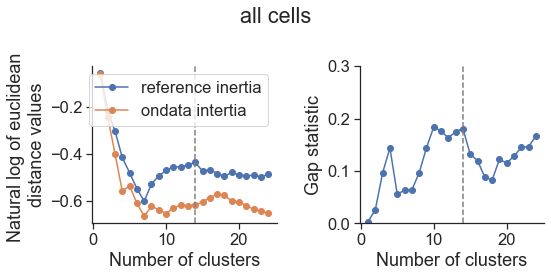

In [21]:
# plotting.plot_gap_statistic is not autoreloading
plotting.plot_gap_statistic(gap_df, cre_lines=['all'], n_clusters_cre=14, 
                            tag='with_cre_shuffle', save_dir=glm_path, folder='')

## Eigen gap

In [22]:
eigengap=processing.load_eigengap(glm_version, feature_matrix, cre_line='all', save_dir=glm_path, k_max=25)

loading eigengap values scores from C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache\GLM\eigengap_24_events_all_L2_optimize_by_session_kmax25all.pkl
done.


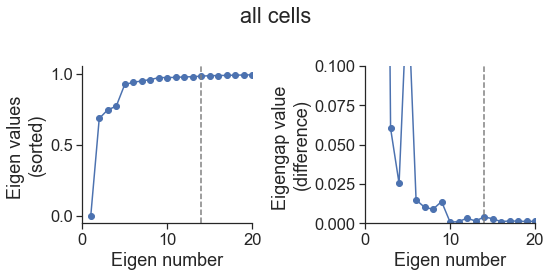

In [23]:
plotting.plot_eigengap_values(eigengap, cre_lines=['all'], n_clusters_cre={'all':14}, save_dir=glm_path, folder='')

## Silhouette Score

In [50]:
from sklearn.cluster import SpectralClustering

X=feature_matrix.values
n_clusters=np.arange(3, 25)
metric='euclidean'
n_boots=20
silhouette_filename= os.path.join(glm_path, 'silhouette_score_{}_{}_clusters_metric_{}_nboots_{}.pkl'.format(n_clusters[0], n_clusters[-1], metric, n_boots))
if os.path.exists(silhouette_filename):
    with open(silhouette_filename, 'rb') as f:
        silhouette_scores, silhouette_std = pickle.load(f)
        print('loaded file')
else:
    
    silhouette_scores, silhouette_std = processing.get_silhouette_scores(X=X, model=SpectralClustering(), n_clusters=n_clusters, metric=metric, n_boots=n_boots)
    processing.save_clustering_results([silhouette_scores, silhouette_std], silhouette_filename)

loaded file


<AxesSubplot:title={'center':', '}, xlabel='Number of clusters', ylabel='Silhouette score'>

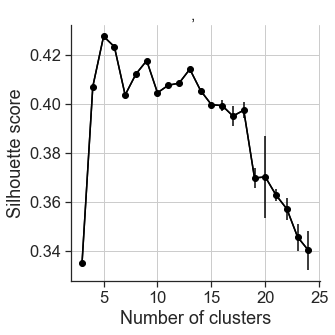

In [25]:

plotting.plot_silhouette_scores(silhouette_scores=silhouette_scores, n_clusters=n_clusters, silhouette_std=silhouette_std,
                             ax=None, model_output_type='')

## Coclustering matrix

In [26]:
from sklearn.cluster import SpectralClustering

In [27]:
# number of optimal clusters
n_clusters = 14

coclust_filename = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')

if os.path.exists(coclust_filename):
    coclustering_df = pd.read_hdf(coclust_filename, key='df')
    print('found and loaded cached coclustering matrix file...')
else:
    print('did not find cached coclustering matrix file, will make one...')
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_file = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
    coclustering_df.to_hdf(coclust_filename, key='df', format='table')
    print('created and saved coclustering_matrix file.')

found and loaded cached coclustering matrix file...


In [28]:
# not clusters coclustering matrix
# sns.heatmap(coclustering_df)

## Hierarchical cluster id assignment

In [29]:
# run agglomerative clustering on co-clustering matrix to identify cluster labels
from sklearn.cluster import AgglomerativeClustering

In [30]:
cluster_meta_filename = os.path.join(glm_path, f'cluster_meta_{n_clusters}_clusters.h5')
if os.path.exists(cluster_meta_filename):
    cluster_meta = pd.read_hdf(cluster_meta_filename,key='df')
    print('found and loaded cached cluster_meta file...')
else:
    print('did not find cached cluster_meta file, will make one...')
    cluster_meta = processing.create_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, cells_table_matched, cluster_meta_filename)
    

found and loaded cached cluster_meta file...


In [31]:
# plot coclustering matrix - need to hack it since it assumes cre lines
# THIS TAKES A LONG TIME (20+ min)
# coclustering_dict = {}
# coclustering_dict['all'] = coclustering_df
# cluster_meta_tmp = cluster_meta.copy()
# cluster_meta_tmp['cre_line'] = 'all'
# plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
#                                                                  save_dir=glm_path, folder='',
#                                                                  suffix='_' + str(n_clusters) + '_clusters', ax=None)

In [32]:
# plot within cluster correlations distribution
# plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=False, suffix='_'+str(n_clusters)+'_clusters',
#                                                save_dir=glm_path, folder='', ax=None)

## main cluster plots

### heatmaps

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


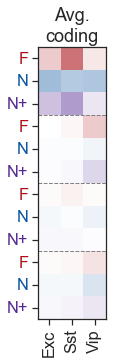

In [33]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, save_dir=glm_path, folder='')

<AxesSubplot:title={'center':'Cluster averages'}, xlabel='Cluster ID'>

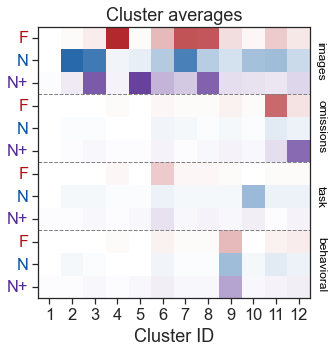

In [34]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=glm_path, folder='', ax=None)

<AxesSubplot:xlabel='cells'>

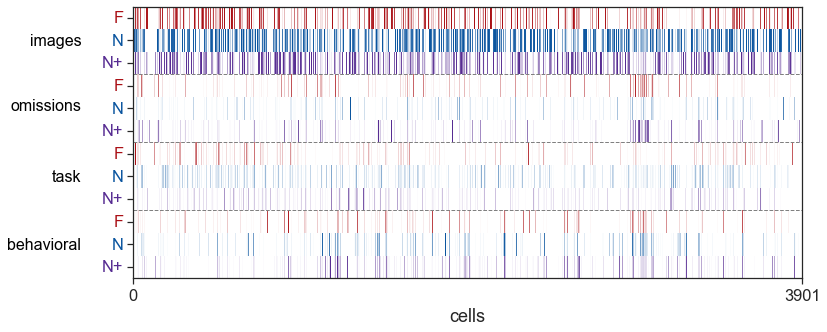

In [35]:
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plotting.plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, session_colors=True,
                                    save_dir=None, folder='', ax=None)

<AxesSubplot:xlabel='Cluster ID'>

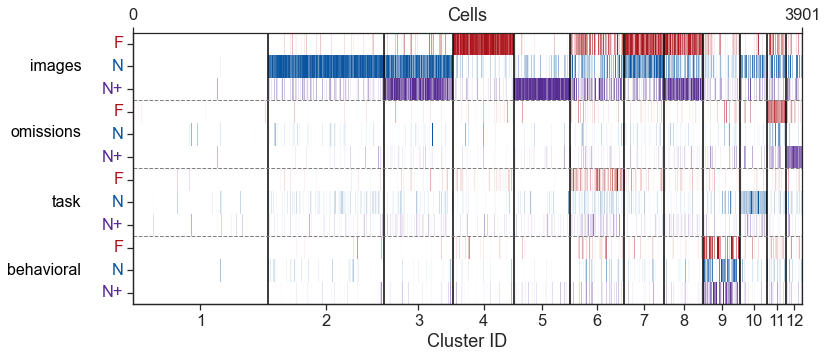

In [36]:
plotting.plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=True,
                                    save_dir=glm_path, folder='', ax=None)

### fraction cells per cluster per cre

12 12
8 12
10 12


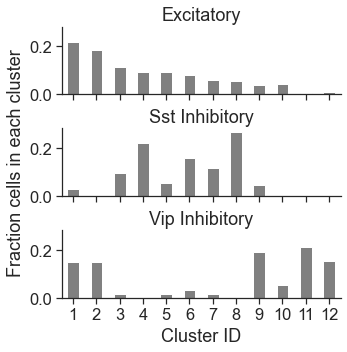

In [37]:
plotting.plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', 
                                                    save_dir=glm_path, folder='')

In [38]:
cell_counts = cluster_meta.groupby(['cell_type']).count().rename(columns={'cre_line':'n_cells'})[['n_cells']]
cell_counts.head()

,n_cells
cell_type,
Excitatory,3298
Sst Inhibitory,194
Vip Inhibitory,409


In [39]:
cell_counts = cluster_meta.reset_index().drop_duplicates(subset='cell_specimen_id').copy()
cell_counts = cell_counts.groupby(['cell_type']).count()
cell_counts.head()

,cell_specimen_id,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_type,,,,,,,,,,,,,,,,,,,,,
Excitatory,3298,3298,3298,3298,3298,3298,3298,3298,3298,3298,...,3298,3298,3298,3298,3298,3298,3298,3298,3298,3298
Sst Inhibitory,194,194,194,194,194,194,194,194,194,194,...,194,194,194,194,194,194,194,194,194,194
Vip Inhibitory,409,409,409,409,409,409,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409


# Cluster description

## Distribution of animals and rigs across clusters

In [40]:
cluster_df=cluster_meta.copy()

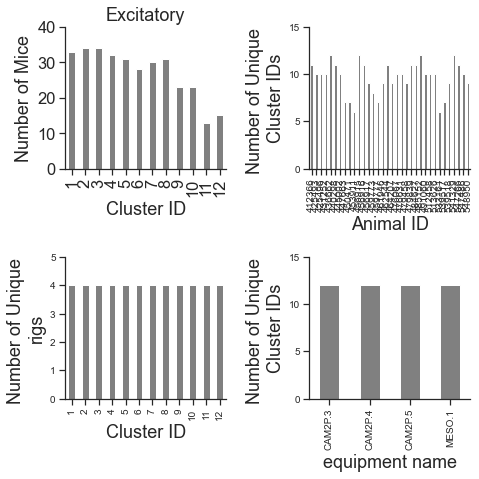

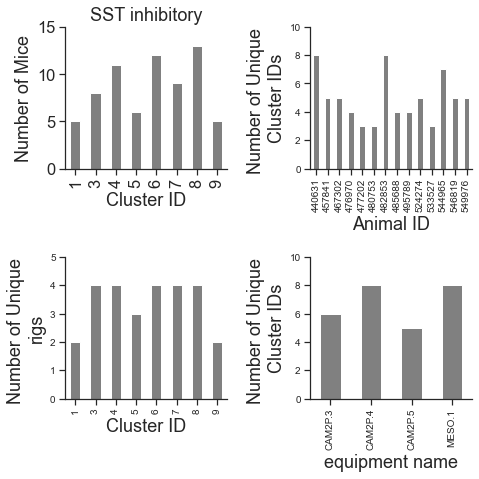

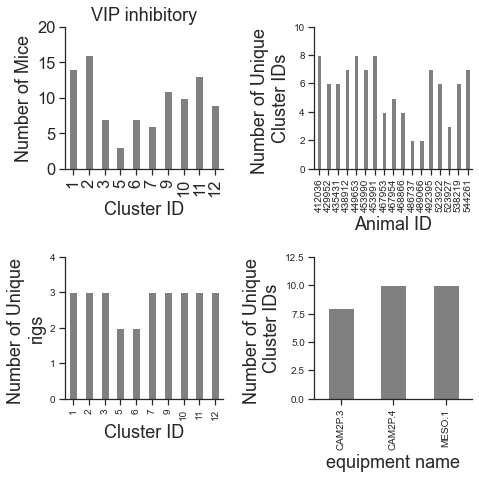

In [41]:
plotting.plot_cluster_info(cre_lines, cluster_df, save_dir=glm_path)

## UMAP

In [82]:
## 20 cells that were matched were dropped 
csids = cluster_meta.index.values
cluster_feature_matrix = feature_matrix.loc[csids]

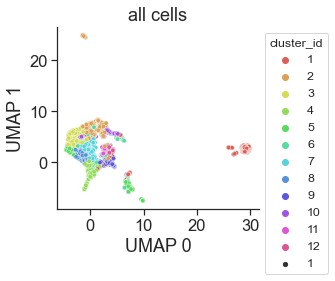

In [86]:
plotting.plot_umap_for_clusters(cluster_meta, cluster_feature_matrix, label_col='cluster_id', cre_lines = ['all'], save_dir=glm_path, folder='')

## Within cluster correlation

In [66]:
cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta,
                                                               use_spearmanr=True)

adding within cluster correlation to cluster_meta


<AxesSubplot:title={'center':'correlation'}, xlabel='cluster #', ylabel='correlation'>

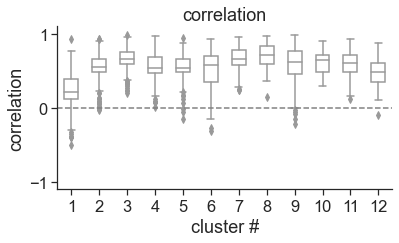

In [67]:
# plot within cluster correlations distribution
n_clusters=14
plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=False, suffix='_'+str(n_clusters)+'_clusters',
                                                save_dir=glm_path, folder='', ax=None)

In [51]:
results_pivoted = across_results[[key for key in across_results.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
results_pivoted['experience_level'] = results_pivoted['experience_level'].replace({'Novel 1': 'Novel', 'Novel >1': 'Novel +'})

In [52]:
### combine cluster meta data and glm output to obtain coding scores metrics


In [53]:
import warnings
warnings.filterwarnings('ignore')
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

In [ ]:
cluster_meta.reset_index()

## Mean image, change, and omissions

### load multiresponse dataframes

In [89]:
import visual_behavior.data_access.loading as loading

In [92]:
    
change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria
image_mdf_filename=os.path.join(glm_path, f'image_df_{change_suffix}.h5')


In [93]:
 image_mdf = pd.read_hdf(image_mdf_filename, key='df')

In [113]:

change_mdf_filename
omission_mdf_filename
data_type = 'filtered_events'
interpolate = True
output_sampling_rate = 30

inclusion_criteria = 'platform_experiment_table'

# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']

change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria


image_mdf_filename=os.path.join(glm_path, f'image_df_{change_suffix}.h5')
if os.path.exists(cluster_meta_filename):
    image_mdf = pd.read_hdf(image_mdf_filename, key='df')
else:
    image_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

    image_mdf = image_mdf[image_mdf.is_change==False]
    image_mdf.to_hdf(image_mdf_filename, key='df')



In [94]:

change_mdf_filename=os.path.join(glm_path, f'change_df_{change_suffix}.h5')
if os.path.exists(change_mdf_filename):
    change_mdf = pd.read_hdf(change_mdf_filename, key='df')
else:
    image_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

    change_mdf = image_mdf[image_mdf.is_change==True]
    change_mdf.to_hdf(change_mdf_filename, key='df')
    

loading files from //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_filtered_events_all_is_change_platform_experiment_table.pkl
loading multi_session_df from saved file at //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_filtered_events_all_is_change_platform_experiment_table.pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


In [98]:
 
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']


omission_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf_filename=os.path.join(glm_path, f'omission_df_{omission_suffix}.h5')
if os.path.exists(omission_mdf_filename):
    omission_mdf = pd.read_hdf(omission_mdf_filename, key='df')
    
else:
    
    omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

    omission_mdf = omission_mdf[omission_mdf.omitted==True]
    omission_mdf.to_hdf(omission_mdf_filename, key='df')
    
    

### image

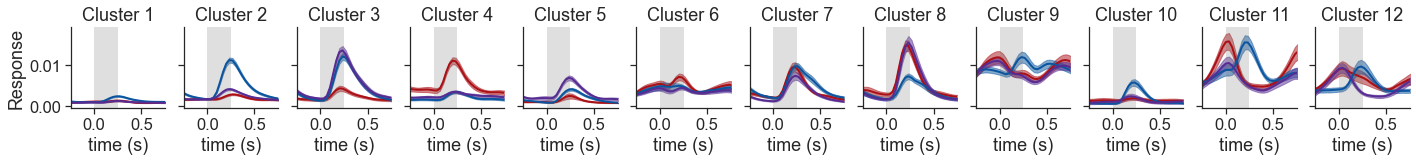

In [103]:
folder = 'figure_4'
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, event_type, axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=glm_path, folder=folder, suffix='_sharey', ax=None);

### change

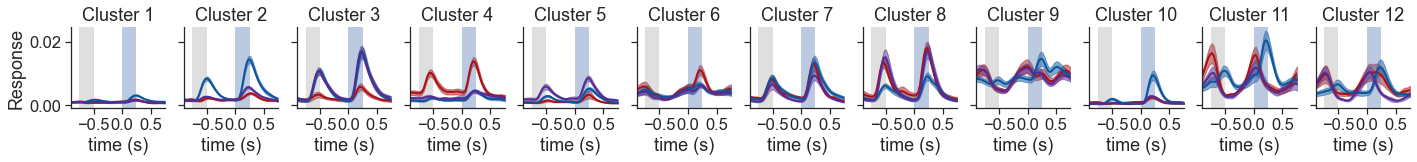

In [105]:
folder = 'suppl_figure_4'
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

xlim_seconds = [-0.9, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=glm_path, folder=folder, suffix='_sharey', ax=None);

### omissions

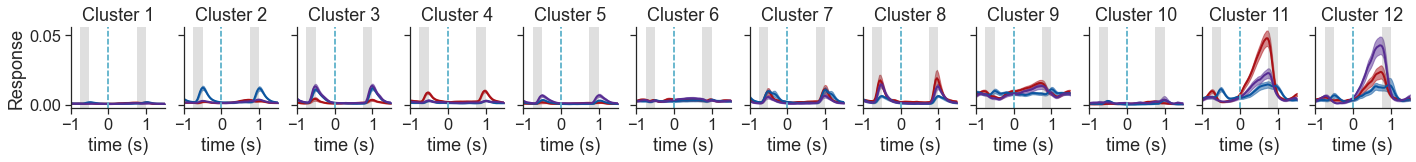

In [107]:
folder = 'suppl_figure_4'
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=glm_path, folder=folder, suffix='_sharey', ax=None);

## Area and depth analysis

In [ ]:
import visual_behavior_glm.GLM_clustering as glm_clust

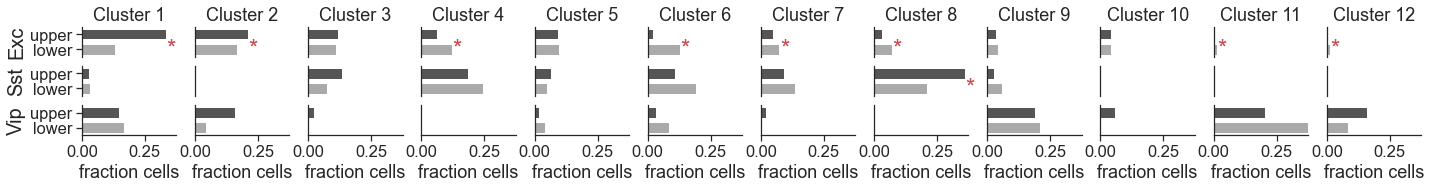

In [110]:
folder = 'figure_4'
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=glm_path, folder=folder);

## Experience modulation across clusters

In [ ]:
coding_score_metrics

In [115]:
coding_score_metrics.keys()

Index(['dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'max_coding_score', 'max_image_coding_score',
       'image_coding_Familiar', 'image_coding_Novel', 'image_coding_Novel +',
       'feature_selectivity', 'experience_selectivity',
       'experience_modulation', 'exp_mod_direction', 'exp_mod_persistence',
       'feature_sel_within_session', 'feature_sel_across_sessions',
       'cluster_id', 'labels', 'ophys_experiment_id', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth

In [116]:
event_type='all'
ppf.plot_experience_modulation_index(coding_score_metrics, event_type, hue=None, plot_type='pointplot', ylims=(-1, 1),
                                     include_all_comparisons=True, save_dir=None)

KeyError: "['cell_specimen_id', 'Novel vs. Familiar', 'Novel + vs. Familiar', 'Novel vs. Novel +'] not in index"

### scatterplot

In [121]:
plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics=, cluster_meta=cluster_meta, y='layer_index', x='exp_mod_direction',
                                               hue='cell_type', save_dir=None, folder=None)

NameError: name 'cluster_metrics' is not defined

# Single cell plots

In [ ]:
import visual_behavior.dimensionality_reduction.clustering.single_cell_plots as scp

#### single cell coding heatmap for schematic

In [ ]:
 # get coding scores for this cell

cell_specimen_id = 1086492467 # excitatory cluster 3 cell 
cluster_id = 2
# cell_specimen_id = 1086509065 # Vip cluster 11 cell 

scp.plot_single_cell_coding_heatmap(cluster_id, cell_specimen_id, feature_matrix, cells_table, save_dir=None, folder=None, ax=None)


In [ ]:
# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

#     for cell_specimen_id in max_csids: 
#         plot_single_cell_coding_heatmap(cluster_id, cell_specimen_id, feature_matrix, save_dir=save_dir, folder=folder, ax=None)


### single cell examples from each cluster

In [ ]:
cluster_id = 10
this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
csids = this_cluster.index.unique()
cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

cell_specimen_id = max_csids[0]

scp.plot_coding_scores_example_cell(cluster_id, cell_specimen_id, feature_matrix, cells_table, single_axis=True, save_dir=save_dir, folder=folder, ax=None)

### mean response examples

In [ ]:
image_responses = image_mdf.copy()
change_responses = change_mdf.copy()
omission_responses = omission_mdf.copy()

## cluster properties

### area / depth proportions for cre lines (this should actually be in figure 2)

In [ ]:
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location='layer')
cre_stats

In [ ]:
location = 'layer'
order = ['upper', 'lower']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


### population average response per cluster

In [ ]:
import visual_behavior_glm.GLM_clustering as glm_clust

In [ ]:
locations = np.sort(cluster_meta.layer.unique())
df = cluster_meta.copy().reset_index()
df['location'] = df.layer

stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

In [ ]:
# this gets the number of cells in different locations compared to the total
n_cells = processing.get_n_cells_per_location_for_clusters(cluster_meta, location='layer')
n_cells.head()

In [ ]:
# this gets the fraction of cells in different locations relative to the total
fraction_cells = processing.get_fraction_cells_relative_to_cluster_size(cluster_meta, location='layer')
fraction_cells.head()

In [ ]:
# this gets all the stats, including n cells, fraction cells, and significance across location comparisons
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location='layer')

n_cells_table.head()

In [ ]:
# compare with Alex's code numbers

locations = np.sort(cluster_meta.layer.unique())
df = cluster_meta.copy().reset_index()
df['location'] = df.layer

stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

conclusion: `processing.get_cluster_proportion_stats_for_locations()` provides the same results as `glm_clust.stats()`, but in an easier to parse format with additional information that is helpful for plotting

### area / depth distributions across clusters

In [ ]:
location = 'layer'
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
x = 'fraction_cells_location'

data = n_cells_table.copy().reset_index()

cre_lines = np.sort(cluster_meta.cre_line.unique())
cell_types = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cre_lines]
cluster_ids = np.sort(cluster_meta.cluster_id.unique())

axes_conditions = np.sort(cluster_meta['cluster_id'].unique())
hue_conditions = np.sort(cluster_meta[location].unique())
n_axes_conditions = len(axes_conditions)

sharey = True 

if sharey == True: 
    wspace = 0.2
    fig_width = 2
else:
    wspace = 0.5
    fig_width = 3.5
    
figsize = (fig_width * n_axes_conditions, 2)
fig, ax = plt.subplots(1, n_axes_conditions, figsize=figsize, sharey=sharey, sharex=True)
ax = ax.ravel()
for i, cluster_id in enumerate(cluster_ids):
    cluster_data = data[data.cluster_id==cluster_id]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cluster_data, x='fraction_cells_location', y='cre_line', order=cre_lines,
                            hue=location, orient='h', palette='gray', width=0.8, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('fraction cells')
    ax[i].set_title('Cluster '+str(cluster_id))
    ax[i].get_legend().remove()
    ax[i].set_ylim(-1.1, len(cre_lines)+0.1)
ax[0].set_yticklabels(cell_types)
ax[i].legend( bbox_to_anchor=(1,1))
# ax[1].set_ylabel('fraction cells in each cluster')
# ax[i].set_xlabel('cluster ID')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

suptitle = ''
if suptitle is not None:
    plt.suptitle(suptitle, x=0.52, y=1.04, fontsize=18)
fig.subplots_adjust(wspace=wspace, hspace=0.75)
if save_dir:
    fig_title = 'fraction_cells_' + location + '_' + x + '_horiz'
    utils.save_figure(fig, figsize, save_dir, folder, fig_title)

#### by layer

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col, sharex=False,
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
location = 'binned_depth'
# order = ['upper', 'lower']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
location = 'binned_depth'
# order = ['upper', 'lower']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=save_dir, folder=folder);

#### by area

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=True, 
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

In [ ]:
# cluster proportions for all cre lines
# this code uses glm_clust.final() to count how many cells per location per cluster per cre, 
# divide it by the total number of cells in each location in each cre
# then subtracts the average proportion across locations for each cluster
# does this make sense??
proportions, stats_final = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines,
                                                                         columns_to_groupby=['layer'])
proportions.head()

In [ ]:
stats = processing.compute_cluster_proportion_stats(cluster_meta.reset_index(), cre_lines[0], location='layer')
stats

In [ ]:
# # computing stats on proportions directly rather than counts - probably wrong

# from scipy.stats import chisquare

# location = 'layer'
# locations = np.sort(cluster_meta[location].unique())
# fraction_per_location_cols = []
# for loc in locations: 
#     fraction_per_location_cols.append('fraction_cells_'+loc)

# # # compute estimated frequency of cells based on average fraction for each cluster
# # for loc in locations:
# #     fraction_cells[loc + '_chance_count'] = fraction_cells['fraction_cells_'+loc].sum() * fraction_cells['mean']
    
# # perform chi-squared test
# for index in fraction_cells.index.values:
#     f = fraction_cells.loc[index][fraction_per_location_cols].values
#     # chance is just the overall size of the cluster
#     f_expected = np.repeat(fraction_cells.loc[index]['fraction_cells_per_cluster'], len(locations))
#     out = chisquare(f, f_expected)
#     fraction_cells.at[index, 'pvalue'] = out.pvalue
#     fraction_cells.at[index, 'significant'] = out.pvalue < 0.05

# # Use Benjamini Hochberg Correction for multiple comparisons
# fraction_cells = processing.add_hochberg_correction(fraction_cells)

# fraction_cells.head()

In [ ]:
# cluster proportions for all cre lines
proportions, stats = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines,
                                                                         columns_to_groupby=['layer'])

In [ ]:
proportions.head()

### cell size by cluster

In [ ]:
cell_info = loading.get_cell_table_from_lims(ophys_experiment_ids=experiments_table.index.values, valid_rois_only=True, platform_paper_only=True)

In [ ]:
experiments_table.keys()

In [ ]:
cre_line = cre_lines[0]
csids = cluster_meta[(cluster_meta.cre_line==cre_line)].index.unique()
cluster_data = cell_info[cell_info.cell_specimen_id.isin(csids)]
cluster_data = cluster_data.merge(cluster_meta['cluster_id'], on='cell_specimen_id')
cluster_data = cluster_data.merge(experiments_table['binned_depth'], on='ophys_experiment_id')

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0] = sns.boxplot(data=cluster_data, x='cluster_id', y='height', ax=ax[0])
ax[1] = sns.kdeplot(data=cluster_data, x='binned_depth', hue='cluster_id', palette=sns.color_palette(), ax=ax[1])
ax[1].axvline(x=250, ymin=0, ymax=1, color='gray', linestyle='--')
sns.move_legend(ax[1], 'upper right', bbox_to_anchor=(1.5,1))
plt.setp(ax[1].get_legend().get_texts(), fontsize='8')  
ax[0].set_title(cre_line)

fig.subplots_adjust(wspace=0.5)
plotting.plot_clusters_row(cluster_meta, feature_matrix, cre_line)


In [ ]:
cre_line = cre_lines[2]
csids = cluster_meta[(cluster_meta.cre_line==cre_line)].index.unique()
cluster_data = cell_info[cell_info.cell_specimen_id.isin(csids)]
cluster_data = cluster_data.merge(cluster_meta['cluster_id'], on='cell_specimen_id')
cluster_data = cluster_data.merge(experiments_table['binned_depth'], on='ophys_experiment_id')

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0] = sns.boxplot(data=cluster_data, x='cluster_id', y='height', ax=ax[0])
ax[1] = sns.kdeplot(data=cluster_data, x='binned_depth', hue='cluster_id', palette=sns.color_palette(), ax=ax[1])
ax[1].axvline(x=250, ymin=0, ymax=1, color='gray', linestyle='--')

sns.move_legend(ax[1], 'upper right', bbox_to_anchor=(1.5,1))
plt.setp(ax[1].get_legend().get_texts(), fontsize='8')  
ax[0].set_title(cre_line)

fig.subplots_adjust(wspace=0.5)
plotting.plot_clusters_row(cluster_meta, feature_matrix, cre_line)


In [ ]:
cre_line = cre_lines[1]
csids = cluster_meta[(cluster_meta.cre_line==cre_line)].index.unique()
cluster_data = cell_info[cell_info.cell_specimen_id.isin(csids)]
cluster_data = cluster_data.merge(cluster_meta['cluster_id'], on='cell_specimen_id')
cluster_data = cluster_data.merge(experiments_table['binned_depth'], on='ophys_experiment_id')

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0] = sns.boxplot(data=cluster_data, x='cluster_id', y='height', ax=ax[0])
ax[1] = sns.kdeplot(data=cluster_data, x='binned_depth', hue='cluster_id', palette=sns.color_palette(), ax=ax[1])
ax[1].axvline(x=250, ymin=0, ymax=1, color='gray', linestyle='--')

sns.move_legend(ax[1], 'upper right', bbox_to_anchor=(1.5,1))
plt.setp(ax[1].get_legend().get_texts(), fontsize='8')  
ax[0].set_title(cre_line)

fig.subplots_adjust(wspace=0.5)
plotting.plot_clusters_row(cluster_meta, feature_matrix, cre_line)


In [ ]:
plotting.plot_clusters_row(cluster_meta, feature_matrix, cre_line)

### image tuning curves per cluster

#### load data

In [ ]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']

inclusion_criteria = 'platform_experiment_table'

In [ ]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change', 'image_name']

suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

# load from single file - takes about 4 mins
save_path = os.path.join(loading.get_multi_session_df_dir(), '113023'+suffix+'.pkl')
each_image_mdf = pd.read_pickle(save_path)


# # load from multi session dfs

# each_image_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
#                                                         interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
#                                                          epoch_duration_mins=None)

# # replace exp level with new one
# each_image_mdf['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in each_image_mdf.experience_level.values]

# # save to pickle 
# save_path = os.path.join(loading.get_multi_session_df_dir(), '113023'+suffix+'.pkl')
# each_image_mdf.to_pickle(save_path)

# save the original as its own variable so you dont have to load it again if you make a mistake
original_each_image_mdf = each_image_mdf.copy()

# remove changes
each_image_mdf = each_image_mdf[each_image_mdf.is_change==False]
# merge with cluster meta 
each_image_mdf = each_image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
len(each_image_mdf.cell_specimen_id.unique())

In [ ]:
# limit to matched cells
print(len(each_image_mdf.cell_specimen_id.unique()))
each_image_mdf = each_image_mdf[each_image_mdf.cell_specimen_id.isin(matched_cells)]
print(len(each_image_mdf.cell_specimen_id.unique()))

#### add image index

 There are different image sets in each experience level so you cant just use the image_name to plot tuning curves beause not all cells have all images. Instead use a generic ID. Also it will be helpful to sort the indices by the mean response, but that can be done during the plotting i think

In [ ]:
each_image_mdf = plotting.add_image_index_column(each_image_mdf)

In [ ]:
each_image_mdf.image_index.unique()

#### plot tuning curve heatmaps per cluster

In [ ]:
# get cluster metrics 
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

In [ ]:
cluster_metrics = cluster_metrics.reset_index()
# get preferred experience level for cluster
cluster_id = 1
# get cells in this cluster 
csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
# get preferred experience level
pref_exp_level = cluster_metrics[cluster_metrics.cluster_id==cluster_id].dominant_experience_level.values[0]

In [ ]:
cre_line = cre_lines[0]

# get image responses for cells in this cluster for pref experience level for a given cre line
df = each_image_mdf[(each_image_mdf.cell_specimen_id.isin(csids)) &
               (each_image_mdf.experience_level==pref_exp_level) & 
               (each_image_mdf.cre_line==cre_line)]
print(len(df.cell_specimen_id.unique()))

In [ ]:
cell_list = plotting.get_cell_list_ordered_by_pref_image_index(df)
len(cell_list)

In [ ]:
plotting.plot_tuning_curve_heatmap_for_cluster(df, cell_list=cell_list, vmax=0.005, sup_title=None, title=None, 
                                          ax=None, save_dir=None, folder=None, 
                                          label='response', colorbar=True)

##### all experience levels together

In [ ]:
plotting.plot_image_tuning_curves_across_experience_for_cluster(each_image_mdf, cluster_metrics, cluster_id=1, 
                                                           vmax = 0.02, cmap='viridis', sort_by_pref_exp_level=True,
                                                           save_dir=None, folder=None)

##### for all clusters

In [ ]:
# # cluster_id = 1
# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):

#     plotting.plot_image_tuning_curves_across_experience_for_cluster(each_image_mdf, cluster_metrics, cluster_id, 
#                                                            vmax = 0.02, cmap='magma', sort_by_pref_exp_level=True,
#                                                            save_dir=save_dir, folder=folder)


### plot cluster average tuning curve sorted by pref image

In [ ]:
# get mean response per image per cell & exp level
image_tcs = each_image_mdf[each_image_mdf.image_name!='omission'].groupby(['cell_specimen_id', 'experience_level', 'image_index']).mean()[['mean_response']]
# sort values by mean responses
sort_tcs = image_tcs.reset_index().sort_values(by=['cell_specimen_id', 'experience_level', 'mean_response'], ascending=False).set_index(['cell_specimen_id', 'experience_level'])
# add sorted image index column
sort_tcs['sorted_image_index'] = np.nan
for index in sort_tcs.index.unique():
    sorted_image_index = np.argsort(sort_tcs.loc[index].mean_response.values)
    sort_tcs.loc[index, 'sorted_image_index'] = sorted_image_index
sort_tcs['sorted_image_index'] = [int(sorted_image_index) for sorted_image_index in sort_tcs.sorted_image_index.values]

# pivot so mean response are columns 
image_tc_pivot = sort_tcs.pivot_table(index=['cell_specimen_id', 'experience_level'] , columns=['sorted_image_index'], values=['mean_response'])
image_tc_pivot.columns = image_tc_pivot.columns.droplevel(0)
# add cluster ID
image_tcs_final = image_tc_pivot.reset_index().merge(cluster_meta[['cluster_id']], on='cell_specimen_id')

In [ ]:

# plot mean TC for each exp level in each cluster
n_clusters = len(cluster_meta.cluster_id.unique())
figsize = (3.5 * 12, 1.5)
fig, ax = plt.subplots(1, 12, figsize=figsize, sharey=True, sharex=True)
ax = ax.ravel()
i = 0
for i, cluster_id in enumerate(np.sort(cluster_meta.cluster_id.unique())):
    for e,experience_level in enumerate(experience_levels):
        cluster_tc = image_tcs_final[(image_tcs_final.experience_level==experience_level) & 
                                     (image_tcs_final.cluster_id==cluster_id)].set_index(['cell_specimen_id', 'experience_level', 'cluster_id']).mean()
        cluster_tc = cluster_tc[::-1] # reverse since its not descending
        ax[i].plot(cluster_tc, color=experience_level_colors[e])
        ax[i].set_title('cluster '+str(cluster_id))
        ax[i].set_xticks(np.arange(0, len(cluster_tc)))
        ax[i].set_xlabel('sorted image index')
        ax[i].set_ylabel('')
ax[0].set_ylabel('mean response')


### plot single cell tuning curves with lifetime sparsness for clusters 

In [ ]:
# first get response metrics to get lifetime sparseness values

import visual_behavior.ophys.response_analysis.cell_metrics as cm

data_type = 'events'

condition = 'images'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

# convert experience level
response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in response_metrics.experience_level.values]

# limit to matched cells
response_metrics = response_metrics[response_metrics.cell_specimen_id.isin(matched_cells)]
len(response_metrics)

In [ ]:
plotting.plot_single_cell_tuning_curve_across_experience_levels(cell_specimen_id, each_image_mdf, response_metrics, 
                                                           save_dir=None, folder=None)

#### plot for all cells

In [ ]:
# # cluster_id = 1
# import random
# for cell_type in cell_types: 
#     print(cell_type)
#     for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#         cell_specimen_ids = cluster_meta[(cluster_meta.cluster_id==cluster_id) & 
#                                         (cluster_meta.cell_type==cell_type)].index.values
#         # randomize so they arent in experiment order
#         random.shuffle(cell_specimen_ids)
#         # only plot 25 cells 
#         if len(cell_specimen_ids) > 25:
#             cell_specimen_ids = cell_specimen_ids[:25]
#         for cell_specimen_id in cell_specimen_ids: 
#             scp.plot_single_cell_tuning_curve_across_experience_levels(cell_specimen_id, each_image_mdf, response_metrics, 
#                                                             save_dir=save_dir, folder=folder)


#### sanity check histograms

In [ ]:
response_metrics = response_metrics.merge(cluster_meta[['cluster_id']], on='cell_specimen_id')

In [ ]:
np.sort(response_metrics.cluster_id.unique())

In [ ]:
# response_metrics['cre_line'] = response_metrics.cre_line_x
# response_metrics['experience_level'] = response_metrics.experience_level_x

In [ ]:
np.sort(response_metrics.cluster_id.unique())

In [ ]:
exc = response_metrics[response_metrics.cre_line=='Slc17a7-IRES2-Cre']

cluster_2_novel = exc[(exc.cluster_id==2)&(exc.experience_level=='Novel')]
cluster_4_familiar = exc[(exc.cluster_id==4)&(exc.experience_level=='Familiar')]

fig, ax = plt.subplots()
ax.hist(cluster_2_novel.lifetime_sparseness.values, bins=50, color='blue', alpha=0.5, label='cluster_2_novel', density=True);
ax.hist(cluster_4_familiar.lifetime_sparseness.values, bins=50, color='red', alpha=0.5, label='cluster_4_familiar', density=True);
ax.set_xlabel('lifetime_sparseness')
ax.set_title('cluster 2 novel vs. cluster 4 familiar')

In [ ]:
exc = response_metrics[response_metrics.cre_line=='Slc17a7-IRES2-Cre']

cluster_2_novel = exc[(exc.cluster_id==2)&(exc.experience_level=='Novel')]
cluster_4_familiar = exc[(exc.cluster_id==4)&(exc.experience_level=='Familiar')]

fig, ax = plt.subplots()
ax.hist(cluster_2_novel.lifetime_sparseness.values, bins=50, color='blue', alpha=0.5, label='cluster_2_novel', density=True);
ax.hist(cluster_4_familiar.lifetime_sparseness.values, bins=50, color='red', alpha=0.5, label='cluster_4_familiar', density=True);
ax.set_xlabel('lifetime_sparseness')
ax.set_title('cluster 2 novel vs. cluster 4 familiar')

### within session changes

In [ ]:
# params for stim response df creation
event_type = 'changes'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change', 'epoch']


suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

epoch_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

# save original so you dont have to reload
original_epoch_mdf = epoch_mdf.copy()
# remove truncated last epoch
epoch_mdf = epoch_mdf[epoch_mdf.epoch!=6]
# add cluster IDs
epoch_mdf = epoch_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

### note this is an mdf for changes only ###

In [ ]:
# plot for all cells within each cre line
ppf.plot_mean_response_by_epoch(epoch_mdf, metric='mean_response', horizontal=True, ymin=0, ylabel='mean response', estimator=np.mean,
                                save_dir=None, folder='epochs', max_epoch=6, suptitle=None, suffix='', ax=None)

In [ ]:

def plot_mean_response_by_epoch_overlay(df, metric='mean_response',ymin=0, ymax=None, ylabel='mean response', estimator=np.mean, max_epoch=6,
                                        title='', legend=True, save_dir=None, folder=folder, suffix='', ax=None):
    """
    Plots the mean metric value across epochs within a session, colored by experience level
    :param df: dataframe of cell activity with one row per cell_specimen_id / ophys_experiment_id
                must include columns 'cell_type', 'experience_level', 'epoch', and a column for the metric provided (ex: 'mean_response')
    :param metric: metric value to average over epochs; must be a column of df
    :param save_dir: top level directory to save figure to
    :param folder: folder within save_dir to save figure to; will create folder if it doesnt exist
    :param suffix: string to append at end of saved filename
    :return:
    """

    experience_levels = np.sort(df.experience_level.unique())

    df = df[df.epoch <= max_epoch]
    epochs = np.sort(df.epoch.unique())

    palette = utils.get_experience_level_colors()
    if ax is None:
        figsize = (6, 3.5)
        fig, ax = plt.subplots(figsize=figsize)

    ax = sns.pointplot(data=df, x='epoch', y=metric, hue='experience_level', hue_order=experience_levels,
                                  order=epochs, palette=palette, ax=ax, estimator=estimator)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if ymax is not None: 
        ax.set_ylim(ymax=ymax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlim((epochs[0] - 1, epochs[-1] + 1))
    ax.set_xticks(epochs)
    ax.set_xticklabels(epochs+1)
    ax.set_xlabel('epoch within session')
    if not legend: 
        ax.get_legend().remove()

    
    if save_dir:
        fig_title = metric + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)
    return ax

In [ ]:
cre_lines = np.sort(epoch_mdf.cre_line.unique())
i = 0
cre_line = cre_lines[i]

cluster_ids = np.sort(epoch_mdf.cluster_id.unique())

for cre_line in cre_lines: 
    if cre_line == 'Slc17a7-IRES2-Cre':
        ymax = 0.032
    elif cre_line == 'Sst-IRES-Cre':
        ymax = 0.06
    elif cre_line == 'Vip-IRES-Cre':
        ymax = 0.05

    figsize=(3.5*len(cluster_ids), 2.5)
    fig, ax = plt.subplots(1, len(cluster_ids), figsize=figsize, sharey=False)
    for i, cluster_id in enumerate(cluster_ids): 
        try: # not all clusters exist in all cre lines
            df = epoch_mdf[(epoch_mdf.cre_line==cre_line) & (epoch_mdf.cluster_id==cluster_id)].copy()

            ax[i] = plot_mean_response_by_epoch_overlay(df, metric='mean_response', ymin=0, ymax=ymax, ylabel='mean response', estimator=np.mean, max_epoch=6,
                                                    title='cluster '+str(cluster_id), legend=False, save_dir=None, folder=folder, suffix='', ax=ax[i])
            ax[i].set_ylabel('')
            ax[i].set_xlabel('')
        except: 
            pass
        ax[i].set_title('cluster '+str(cluster_id))

    ax[0].set_ylabel('mean response')
    ax[int(len(cluster_ids)/2.)].set_xlabel('epoch within session')

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(cre_line, x=0.52, y=1.2)

### cluster metrics vs. area depth proportion

#### get metrics

In [ ]:
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)
coding_score_metrics.head()

In [ ]:
# cluster_metrics_all_cre = processing.get_cluster_metrics_all_cre(cluster_meta, feature_matrix, results_pivoted)
# cluster_metrics_all_cre.head()

In [ ]:
# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.head()

#### link cluster metrics to area depth

In [ ]:

# cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
# cluster_metrics.head()

location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

n_cells_table.head()                                                              
cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)
cluster_metrics.head()

In [ ]:
x = 'layer_index' # upper-lower / sum
y = 'exp_mod_direction' # novel-familiar / sum
hue = 'cre_line'

plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


#### proportion of cells in each cre line preferring each feature & exp level (should be in fig 3)

In [ ]:
metric = 'dominant_feature'
c = sns.color_palette()
palette = [c[2], c[9], c[1], c[8]]
title = 'maximaly contributing\nfeature distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=False, ax=None)


In [ ]:
metric = 'dominant_feature'
c = sns.color_palette()
palette = [c[2], c[9], c[1], c[8]]
title = 'maximaly contributing\nfeature distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=True, ax=None)


In [ ]:
column_to_group = 'dominant_experience_level'
n_cells = coding_score_metrics.reset_index().groupby(['cre_line', column_to_group]).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id': 'n_cells'})
total_cells = coding_score_metrics.reset_index().groupby(['cre_line']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id': 'total_cells'})
fraction_cells = n_cells.reset_index().merge(total_cells, on='cre_line', how='left')
fraction_cells['fraction'] = fraction_cells.n_cells/fraction_cells.total_cells
fraction_cells

In [ ]:
metric = 'dominant_experience_level'
palette = experience_level_colors
title = 'maximaly contributing\nexperience level distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=False, ax=None)


In [ ]:
metric = 'dominant_experience_level'
palette = experience_level_colors
title = 'maximaly contributing\nexperience level distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=True, ax=None)


### split by cre line and plot heatmaps

In [ ]:
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', resort_by_size=True, save_dir=None, folder=folder)


In [ ]:
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=True,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder=folder)

In [ ]:
# plot feature matrix sorted by cluster ID
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=False,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder=folder)

### average dropouts per cluster - updated colors

In [ ]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)


feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+str(n_clusters))

#### averages per cre line 

In [ ]:
# all cre lines on one plot

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters = len(clusters)

figsize = (2.5*n_clusters, 2.5*3)
fig, ax = plt.subplots(3, n_clusters, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

i=0
for c, cre_line in enumerate(np.sort(cluster_meta.cre_line.unique())):
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    # loop through clusters in sorted order
    for x, cluster_id in enumerate(clusters):
        try:
            this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
            mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
            ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
            # fraction is number of cells in this cluster vs all cells in this cre line
            fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
            fraction = np.round(fraction_cluster * 100, 1)
            # set title and labels
            ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
            ax[i].set_xlabel('')
        except:
            pass
        i+=1
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    # plt.suptitle(cre_line, x=0.46, y=1.)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped')

In [ ]:
# plot and sort each cre line separately

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()
    # clusters = np.sort(cre_cluster_meta['cluster_id'].unique())
    # sort by cluster size
    clusters = cre_cluster_meta['cluster_id'].value_counts().index.values
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+cre_line.split('-')[0])

#### sort by cluster size within cre, exclude clusters with <10% cells

In [ ]:
cluster_metrics_per_cre = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics_per_cre = cluster_metrics_per_cre.reset_index()
# cluster_metrics_per_cre = cluster_metrics_per_cre[(cluster_metrics_per_cre.cre_line==cre_line)&(cluster_metrics_per_cre.n_cells_cluster>10)]
cluster_metrics_per_cre.head()

In [ ]:
# plot clusters in order of sort_col

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    clusters_to_include = cluster_metrics_per_cre[(cluster_metrics_per_cre.cre_line==cre_line)&(cluster_metrics_per_cre.n_cells_cluster>10)].cluster_id.unique()
    clusters = cre_cluster_meta[cre_cluster_meta.cluster_id.isin(clusters_to_include)]['cluster_id'].value_counts().index.values    
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_sorted_'+cre_line.split('-')[0])

### cre line proportions per cluster (old version)

In [ ]:
col_to_group = 'cre_line'
n_cells_per_cluster = processing.get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue=col_to_group, hue_order=cre_lines, palette=cre_line_colors, width=0.5, ax=ax)
ax.set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
# sorted within cre
col_to_group = 'cre_line'
n_cells_per_cluster = processing.get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (25,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre in enumerate(cre_lines):
    cre_data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre]
    order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x='cluster_id', order=order, y='fraction_per_cluster', 
                hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, width=0.5, ax=ax[i])
    ax[i].set_ylabel('fraction in each cluster')
    ax[i].get_legend().remove()
    ax[i].set_ylim(0, 0.3)
#     ax[i].legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')
    ax[i].set_title(cre)

#### per mouse

In [ ]:
col_to_group = 'mouse_id'
n_cells_per_cluster = processing.get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)
n_cells_per_cluster = n_cells_per_cluster.merge(experiments_table[['mouse_id', 'cre_line']], on='mouse_id')
n_cells_per_cluster = n_cells_per_cluster.drop_duplicates(subset=['mouse_id', 'cluster_id'])
n_cells_per_cluster

In [ ]:
figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.barplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, ax=ax)
ax.set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
figsize = (20,4)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre_line]
    ax[i] = sns.stripplot(data=data, x='cluster_id', y='fraction_per_cluster', 
                          order=np.arange(0, len(n_cells_per_cluster.cluster_id.unique())),
                color=cre_line_colors[i], ax=ax[i])
    ax[i] = sns.barplot(data=data, x='cluster_id', y='fraction_per_cluster', 
                        order=np.arange(0, len(n_cells_per_cluster.cluster_id.unique())),
                color='gray', ax=ax[i])
    ax[i].set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
    ax[i].set_title(cre_line)

## graphical abstract figure 

Goal: make figure representing the major clusters for each cre line, with each cluster represented as one point (cell) using the color for experience modulation, shape for cre line, y position for type and strength of coding, x position for area-depth bias

* Use pref exp level (or index) for color of fill
* Pref feature for x position (strength of coding for each as order)
* Get upper v. lower for significant diffs, set as y position; nonsig in middle
* Cre lines as shapes
* Only include clusters with >5% cells

#### get data

In [ ]:
# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.head()

In [ ]:
location = 'layer'
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table.head()

In [ ]:
layer_index = n_cells_table[['fraction_cells_location']].unstack()
layer_index.columns = layer_index.columns.droplevel(0)
layer_index['layer_index'] = (layer_index.upper-layer_index.lower)/(layer_index.upper+layer_index.lower)
layer_index = layer_index.merge(n_cells_table[['bh_significant', 'significant']], on=['cre_line', 'cluster_id'])
layer_index = layer_index.reset_index().drop_duplicates(subset=['cre_line', 'cluster_id']).set_index(['cre_line', 'cluster_id'])
layer_index.head()

#### seaborn plot

In [ ]:
# get data to plot
df = cluster_metrics.merge(layer_index, on=['cre_line', 'cluster_id']).sort_values(by='max_coding_score')
df = df[df.fraction_cre>0.07]

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]
# markers for cre lines 
marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# make plot
figsize = (6,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=df.reset_index(), x='max_image_coding_score', y='layer_index', 
                hue='exp_mod_direction', palette='RdBu', size='fraction_cre', sizes=(1,500),
                markers=marker_dict, style='cre_line', edgecolor='gray', ax=ax)
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small', title_fontsize='x-small')
# ax.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=1)
ax.set_title('Size, location, coding strength,\n and experience dependence for major clusters')
ax.set_ylabel('layer bias\n<- lower --- upper ->')
ax.set_xlabel('image coding strength ->')
ax.set_ylim(-0.8, 0.8)
sns.despine(left=True, bottom=True)
for index in df.index.values:  
    cluster_id = index[1]
    x_pos = df.loc[index, 'max_image_coding_score']
    y_pos = df.loc[index, 'layer_index']
    size = df.loc[index, 'fraction_cre']
    ax.text(x=x_pos+size*0.1, y=y_pos+size*0.1, s=str(cluster_id), fontsize=12, color='k', ha='left', va='bottom')

In [ ]:
# get data to plot
df = cluster_metrics.merge(layer_index, on=['cre_line', 'cluster_id']).sort_values(by='max_coding_score')
df = df[df.fraction_cre>0.04]

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]
# markers for cre lines 
marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# make plot
figsize = (6,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=df.reset_index(), x='max_image_coding_score', y='layer_index', 
                hue='exp_mod_direction', palette='RdBu', size='fraction_cre', sizes=(1,500),
                markers=marker_dict, style='cre_line', ax=ax)
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small', title_fontsize='x-small')
# ax.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=1)
ax.set_title('Size, location, coding strength,\n and experience dependence across clusters')
ax.set_ylabel('layer bias\n<- lower --- upper ->')
ax.set_xlabel('image coding strength ->')
ax.set_ylim(-0.8, 0.8)
sns.despine(left=True, bottom=True)
for index in df.index.values:  
    cluster_id = index[1]
    x_pos = df.loc[index, 'max_image_coding_score']
    y_pos = df.loc[index, 'layer_index']
    ax.text(x=x_pos+0.01, y=y_pos+0.01, s=str(cluster_id), fontsize=12, color='gray', ha='left', va='bottom')

#### matplotlib version

In [ ]:
features = ['all-images', 'omissions', 'task', 'behavioral',]

marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

# plot in order of features
for f, feature in enumerate(features): 
    # get clusters with specific preferred feature
    feature_data = df[(df.dominant_feature==feature) & (df.fraction_cre>0.04)] # only consider clusters with >4% cells
    # sort clusters by max coding score for pref feature
    feature_data = feature_data.sort_values(by='max_coding_score')
    # loop through clusters
    for index in feature_data.index.values: 
        cluster_data = feature_data.loc[index]
        # x position determined by strength of max coding score (which corresponds to the pref feature)
        x_pos = cluster_data.max_coding_score
        # y position is the upper v lower index value (i.e. layer bias of cluster)
        y_pos = cluster_data.layer_index
        # get color for exp mod index by rounding and indexing into discritized color map
        exp_mod_value = np.round(cluster_data.exp_mod_direction, 1)
        color_index = np.where(value_order==exp_mod_value)[0][0]
        color = colors[color_index]
        # get marker for cre line
        cre_line = index[0] # zero index is cre line, get maker for cre line
        marker = marker_dict[cre_line] 
        cluster_id = index[1] # get cluster Id for label
        ax.plot(x_pos, y_pos, marker=marker, ms=20, label=utils.get_abbreviated_cell_type(cre_line)+'-'+str(cluster_id),
                markerfacecolor=color, markeredgecolor='black')

ax.set_ylim(-1, 1)
ax.legend(bbox_to_anchor=(1,1))

#### which clusters form the top 3 in each cre line?

In [ ]:
.21+.19+.15 # Vip - 11, 9, 12

In [ ]:
.27+.22 # Sst - 8, 4

In [ ]:
.22+.18+.11 # Slc - 1, 2, 3, 

In [ ]:
cluster_metrics.reset_index().sort_values(by=['cre_line', 'fraction_cre'], ascending=False)[['cre_line', 'cluster_id', 'fraction_cre']]

## selecting # k

### is 15 clusters reasonable?

### eigengap

In [ ]:
# k_max=25
# X = feature_matrix.values
# sc = SpectralClustering(n_clusters)  # N of clusters does not impact affinity matrix
# # but you can obtain affinity matrix only after fitting, thus some N of clusters must be provided.
# sc.fit(X)
# A = sc.affinity_matrix_
# eigenvalues, eigenvectors, nb_clusters = processing.get_eigenDecomposition(A, max_n_clusters=k_max)

In [ ]:
# figsize = (10, 4)
# fig, ax = plt.subplots(figsize=figsize)
# # ax.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, '-o')
# # ax.set_ylabel('Eigen values \n(sorted)')
# # ax.set_xlabel('Eigen number')
# # ax.set_xlim([0, 20])
# # ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

# ax.plot(np.arange(2, len(eigenvalues) + 1), np.diff(eigenvalues), '-o')
# ax.set_ylabel('Eigengap value \n(difference)')
# ax.set_xlabel('Eigen number')
# ax.set_xlim([0, 20])
# # ax.set_ylim([0, 0.20])
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')
# plt.tight_layout()

# if test_save_dir:
#     utils.save_figure(fig, figsize, test_save_dir, 'figs', 'eigengap')

### compute metrics on dropout scores for each cell

In [ ]:
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

metrics: 
* exp_mod_direction = N - F / N + F
* exp_mod_persistence = N+ - N / N+ + N

In [ ]:
metric = 'exp_mod_direction'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel('(N - F / N + F)')
ax.set_title('novelty modulation index')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
n_clusters = len(coding_score_metrics.cluster_id.unique())

In [ ]:
# take absolute value so its just whether it is transient or not, regardless of direction
coding_score_metrics['transience'] = 1-np.abs(coding_score_metrics.exp_mod_persistence.values)

### correlate coding score metrics with area / depth distributions

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

### dropout heatmaps

In [ ]:
cluster_id = 1

plotting.plot_dropout_heatmap(cluster_meta, feature_matrix, cluster_id, cre_line=None, 
                            abbreviate_features=True, abbreviate_experience=True, small_fontsize=False, ax=None)

### pie chart fraction cells per cluster